# Ciência dos Dados
## Projeto 2 - Walmart
### Integrantes do Grupo

* Antônio Amaral Egydio Martins
* Arthur Martins de Souza Barreto

### Professor Orientador
* Maria Kelly Venezuela

___

### Índice

___
### Proposta Norteadora
* Contextualização:
* Objetivo:

Buscamos entender como o meio interno e externo impactam diretamente na quantidade de itens vendidos no WalMart nos Estados Unidos entre 5/2/2010 até 1/11/2012. Sendo assim para este trabalho utilizaremos como Feature interna o ID da loja - que pode impactas nas vendas por existirem diferentes lojas em diferentes locais… - e como Features Externas os índices CPI (Prevailing consumer price index), Fuel Price, Unemployment e Temperature que afetam diretamente o bem estar e poder aquisitivo do consumidor - podendo aumentar ou reduzir seu consumo semanal.
____

### Introdução
* Importando bibliocas utilizadas:

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sn
import statsmodels.api as sm

from scipy.stats import probplot
# bibliotecas para analize e predições
from sklearn.model_selection import train_test_split
# Modelo de regresão linear
from sklearn import linear_model
# metricas sklearn
from sklearn.metrics import mean_squared_error, r2_score
#Modelo DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
#Modelo Random Forest
from sklearn.ensemble import RandomForestRegressor

* Importando base de dados

In [4]:
#Checando Diretório 
print("Esperamos trabalhar no diretório")
print(os.getcwd())

Esperamos trabalhar no diretório
/Users/antonioamaralegydiomartins/Desktop/Antônio/GitHub - Pessoal/INSPER/Formula1_predicting_lap_time


In [5]:
df = pd.read_csv('Walmart_Store_sales.csv')
df.describe()


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


* Funções

In [241]:
# Função para definir o grupo dado a correlação da loja
def grupo(Data):
    # se correlação da temperatura for menor que -0.3, temos o grupo -1, correlaçãoo modera forte negativa
    if Data < -0.3:
        return -1
    # se for maior que 0.4, temos o grupo 1, correlação moderada forte positica
    elif Data > 0.3:
        return 1
    else:
        # caso contrario, temos o grupo 0, ou seja, correlação fraca, seja negativa ou positiva
        return 0

def lista_datas ():
    Dados = df.loc[df["Store"]==1,:]
    Date = Dados["Date"]
    Date.sort_values()
    return Date.tolist()

def correlacao (DataFrame,indicadores, target, store):#Criando Dicionario Principal - Será Base do Novo DataFrame de Correlações
    principal = {}
    dads = DataFrame
    for loja in range(1,46):
        #Dicionario Index
        secundario = {}
        #Separando dados de lojas individuais
        Dados = dads.loc[dads[store]==loja,:]
        for indicador in indicadores:
            #Pegando Dados de Indicadores escolhidos da Loja Inputada e adicionando ao Index
            corr = Dados[target].corr(Dados[indicador])
            secundario[indicador] = corr
        principal[loja] = secundario
    X_Data = pd.DataFrame.from_dict(principal).transpose()
    return X_Data

def dados_grafico_holiday_flag_data(DataFrame):
    #Separando Dados Para Plot de Weekly Sales e Holiday Flag
    DFhf = DataFrame.loc[DataFrame["Store"]==1,:]
    data_2010_2011 = DFhf.loc[DFhf["Date"] <= "2010-10-02"]
    data_2010_2011 = DFhf.loc[DFhf["Date"] >= "2011-07-01"].sort_values(by="Date")
    data_2011_2012 = DFhf.loc[DFhf["Date"] <= "2011-10-7"]
    data_2011_2012 = DFhf.loc[DFhf["Date"] >= "2012-01-27"].sort_values(by="Date")
    #Definindo Listas
    B2 = []
    B2T = []
    B = []
    BT = []
    L_Index = data_2010_2011["Weekly_Sales"].index
    L_Index2 = data_2011_2012["Weekly_Sales"].index
    #Utilizando For e If para reconhecer os pontos em que Holiday Flag = 1.
    for e in L_Index:
        if data_2010_2011["Holiday_Flag"][e] == 1:
            B.append(data_2010_2011["Weekly_Sales"][e])
            BT.append(data_2010_2011["Date"][e])

    for e in L_Index2:
        if data_2011_2012["Holiday_Flag"][e] == 1:
            B2.append(data_2011_2012["Weekly_Sales"][e])
            B2T.append(data_2011_2012["Date"][e])
    return B2, B2T, B, BT

def dados_grafico_hf(DataFrame):
        #Separando Dados Para Plot de Weekly Sales e Holiday Flag
    DFhf = DataFrame.loc[DataFrame["Store"]==1,:]
    DFhf = dft.sort_values(by="Date")
    #Definindo Listas
    B = []
    BT = []
    L_Index = DFhf["Weekly_Sales"].index
    #Utilizando For e If para reconhecer os pontos em que Holiday Flag = 1.
    for e in L_Index:
        if DFhf["Holiday_Flag"][e] == 1:
            B.append(DFhf["Weekly_Sales"][e])
            BT.append(DFhf["Date"][e])
            
    return B, BT



def variavel_baixa (DataFrame, feature):
    #Definindo DataFrame recebico
    DFpreco = DataFrame
    #Banco de Variaveis
    loja_menor = 1e10
    ID_menor = 0
    loja_maior = 0
    ID_maior = 0
    #Index - Reconhecimento das posições
    Index = DFpreco[feature].index
    for e in Index:
        if DFpreco[feature][e] > loja_maior:
            loja_maior = DFpreco[feature][e]
            ID_maior = DFpreco["Store"][e]
        if DFpreco[feature][e] < loja_menor:
            loja_menor = DFpreco[feature][e]
            ID_menor = DFpreco["Store"][e]
    lojas = []
    lojas.append(ID_menor)
    lojas.append(ID_maior)
    menor_variavel = []
    maior_variavel = []
    porcentagem = []
    for loja in lojas:
        Dados = DFpreco.loc[DFpreco["Store"]==loja,:]
        minimo = Dados[feature].min()
        maximo = Dados[feature].max()
        menor_variavel.append(minimo)
        maior_variavel.append(maximo)
        porcentagem.append((maximo/minimo)*100)
   
    #Lojas Menor = [0] e Maior = [1]
    return lojas, porcentagem

In [165]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

### Analise Exploratoria

Após o termico do carregamento da base de dados, e a checagem da integridade dos dados que serão utilizados. Haverá o inicio da Analise Exploratoria que terá foco inicial em apresentar informações básicas sobre as Features e Target utilizadas.

___
<center><b>Dicionário de dados do DataSet:</b></center>


Variável | Descrição
:---:|---:
Store | ID de Reconhecimento das Lojas
Weekly_Sales | Vendas Semanais
Holiday_Flag | Variavel Booleana para Feriados 
Temperature | Temperatura Exterior as lojas (Fahrenheit)
Fuel_Price | Preço do Galão de Combustivel (USD)
CPI (Prevailing consumer price index) | Unidade utilizada para medir inflação
Unemployment | Taxa de Desemprego (%)

<center>A variável *Holiday_Flag* identifica se é feriado ou não de forma Booleana.</center>

Valor | Significado
:---:|:---:
0 | É Feriado
1 | Não é Feriado

___

#### Target:
    - Weekly Sales
#### Features:
    - Holiday Flag
    - Temperature
    - Fuel Price
    - CPI
    - Unemployment
    
___

#### Visualização Gráfica

Nesta Seção será realizado o Plot de Gráficos Temporais e Correlacionais, para estabelecer a apresentação visual dos dados com relação ao tempo, e já pré-definir correlações entre os mesmos.

As <b>Features</b> usadas serão:
* `Temperature`
* `Fuel_Price`
* `CPI`
* `Unemployment`

E da Variavel principal <b>Target</b>:
* `Weekly_Sales`

`Gráficos Temporais`

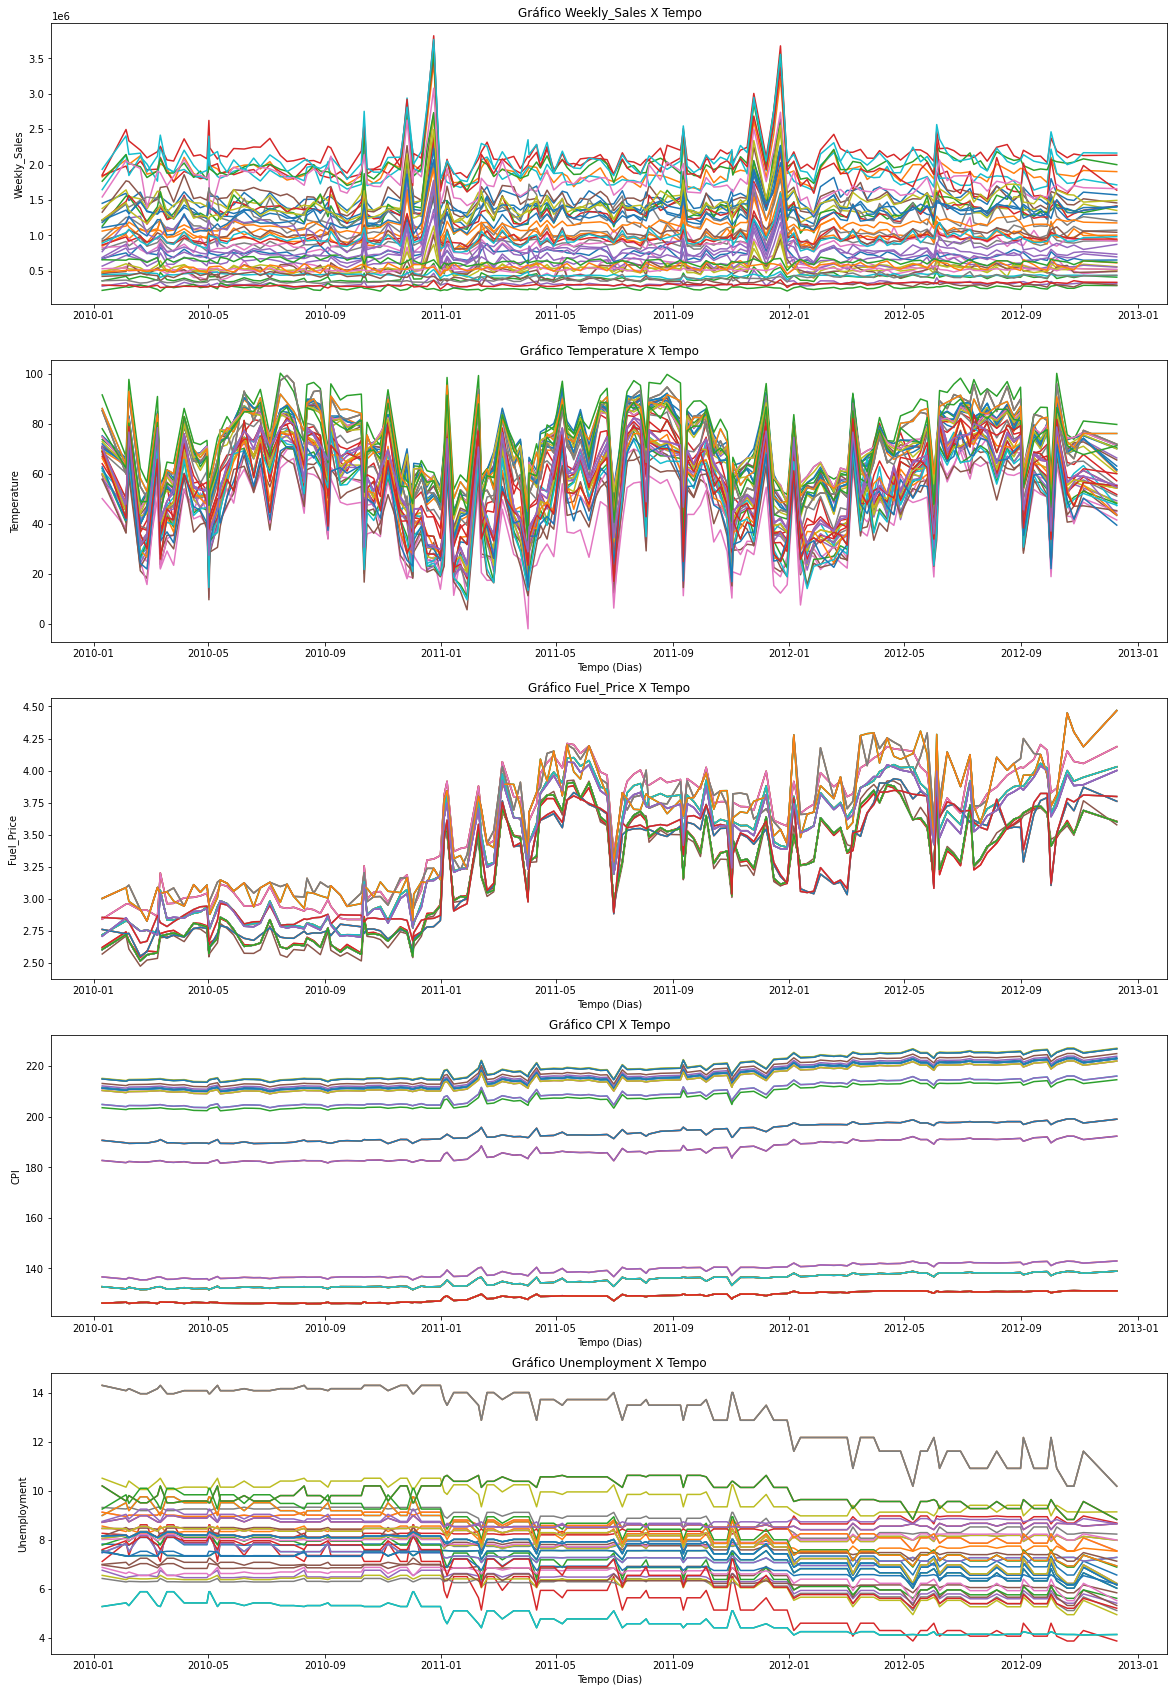

In [150]:
dft = df.copy()
dft.Date = pd.to_datetime(dft.Date)
dft_ordenado = dft.sort_values(by='Date')
l_variaveis = ["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment"]
l_subplots = [511,512,513,514,515]
plt.figure(figsize = (20,30))

index = 0
for variavel in l_variaveis:
    plt.subplot(l_subplots[index])
    for loja in range(1,46):
        dados_loja = dft_ordenado.loc[dft['Store'] == loja]
        plt.plot(dados_loja.Date, dados_loja[variavel])
        plt.title(f"Gráfico {variavel} X Tempo")
        plt.ylabel(variavel)
        plt.xlabel("Tempo (Dias)")
    index += 1
plt.show()

`Interpretação Gráficos Temporais`

* Weekly_Sales

O gráfico temporal da Target apresenta relação cíclica dos dados, uma vez que existem grandes quedas nos primeiros meses do ano, e grandes altas ao final do ano. Para saber se essas altas e quedas são causadas por eventos especiais ou feriados, segue gráfico abaixo:

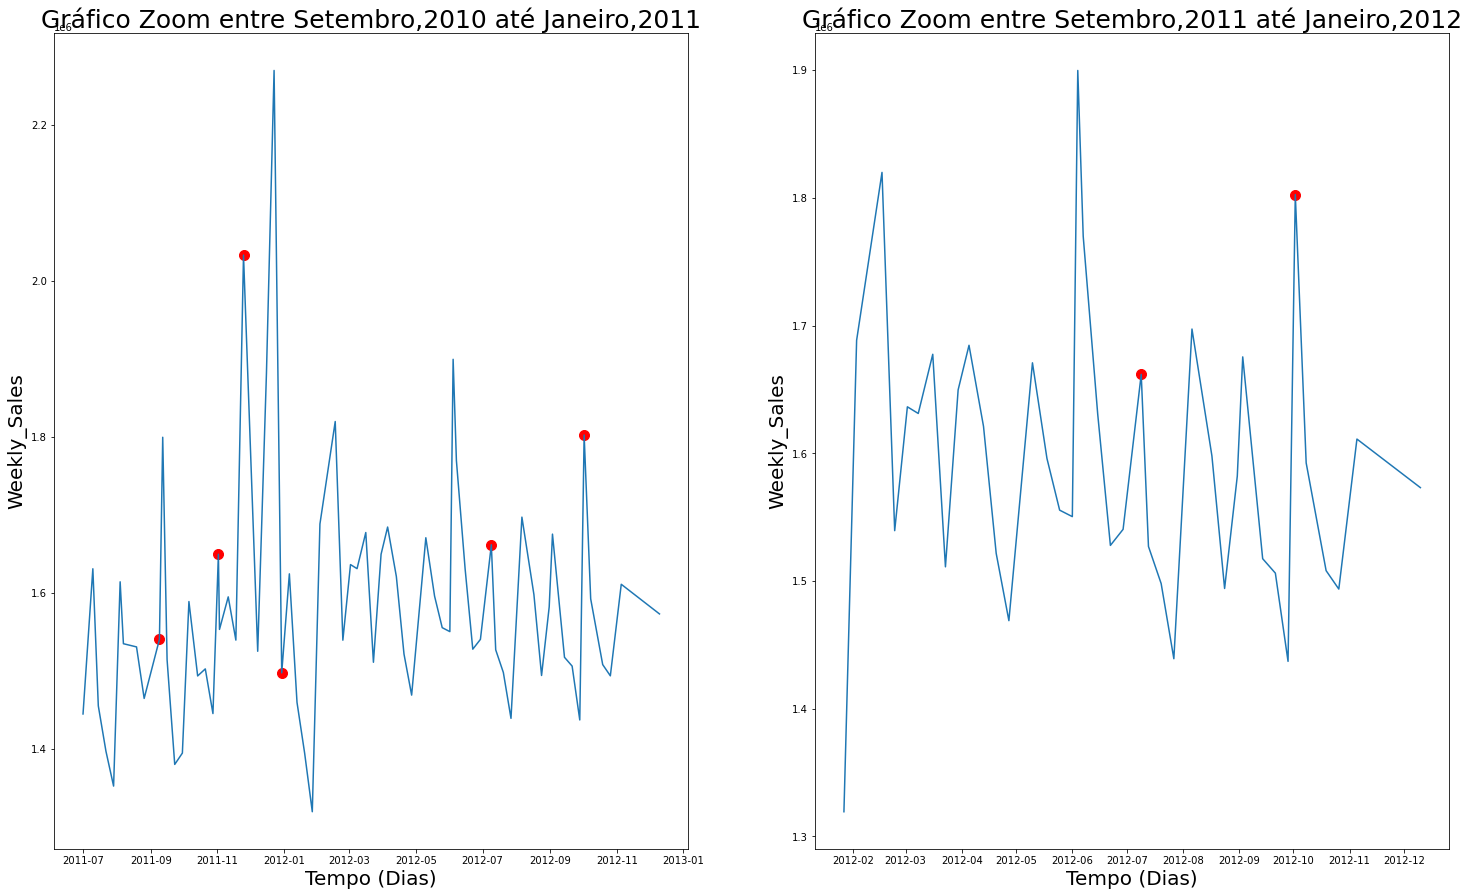

In [154]:
B2, B2T, B, BT = dados_grafico_holiday_flag_data(dft)
#Plot Gráfico
plt.figure(figsize=(25,15))
plt.subplot(121)
plt.plot()
plt.scatter(BT, B, c="red",s=100)
plt.plot(data_2010_2011["Date"],data_2010_2011["Weekly_Sales"])
plt.xlabel("Tempo (Dias)", fontsize=20)
plt.ylabel("Weekly_Sales", fontsize=20)
plt.title("Gráfico Zoom entre Setembro,2010 até Janeiro,2011", fontsize=25)
plt.subplot(122)
plt.scatter(B2T, B2, c="red",s=100)
plt.plot(data_2011_2012["Date"],data_2011_2012["Weekly_Sales"])
plt.xlabel("Tempo (Dias)", fontsize=20)
plt.ylabel("Weekly_Sales", fontsize=20)
plt.title("Gráfico Zoom entre Setembro,2011 até Janeiro,2012", fontsize=25)
plt.show()

Para a facção deste gráfico foi escolhida a primeira loja da lista de lojas, representada pelo ID 1 - esta escolha foi realizada com merito totalmente explicativo, deixando o gráfico simples, e apresentando a relação que a feature holiday_flag pode ter com o aumento ou decressimo de vendas semanais. Como é possível observar no caso da loja 1 não é possível conectar a existencia de eventos especiais ou feriados com o aumento das vendas ao final dos anos.

* Temperature

Não é possível retirar conclusões diretas do gráfico temporal da feature “Temperature”, uma vez que aparenta apresentar comportamento cíclico, porém com altas e quedas extremamente agudas, e não periódicas.

* Fuel_Price

O gráfico temporal da feature “Fuel_Price” apresenta relação de crescimento conforme o tempo, sendo este crescimento de 62,83% para a loja com Fuel_Price inicial mais baixo e 63,227% para a loja com o preço inicial mais alto. Podendo haver quedas cíclicas, mas que não serão aprofundadas neste trabalho uma vez que essas varianças não podem ser justificadas por movimento inflacionário.

In [244]:
lojas, porcentagens = variavel_baixa(dft,"Fuel_Price")
print(f"A loja com Fuel_Price inicial mais baixo foi a {lojas[0]} tendo crescimento de {porcentagens[0]-100:.3f}%")
print(f"A loja com Fuel_Price inicial mais alto foi a {lojas[1]} tendo crescimento de {porcentagens[1]-100:.3f}%")
#Loja com Preço Final mais Alto

A loja com Fuel_Price inicial mais baixo foi a 36 tendo crescimento de 59.142%
A loja com Fuel_Price inicial mais alto foi a 10 tendo crescimento de 58.159%


* CPI

O Gráfico temporal da feature “CPI” apresenta relação de crescimento conforme o tempo, sendo o mesmo:

In [245]:
lojas, porcentagens = variavel_baixa(dft,"CPI")
print(f"A loja com CPI inicial mais baixo foi a {lojas[0]} tendo crescimento de {porcentagens[0]-100:.3f}%")
print(f"A loja com CPI inicial mais alto foi a {lojas[1]} tendo crescimento de {porcentagens[1]-100:.3f}%")

A loja com CPI inicial mais baixo foi a 4 tendo crescimento de 4.069%
A loja com CPI inicial mais alto foi a 9 tendo crescimento de 6.260%


* Unemployment

O gráfico temporal da feature “Unemployment” apresenta uma relação de decréscimo conforme o tempo, sendo esta movimentação de % para a loja e % para a loja.

`Gráficos de Correlação`

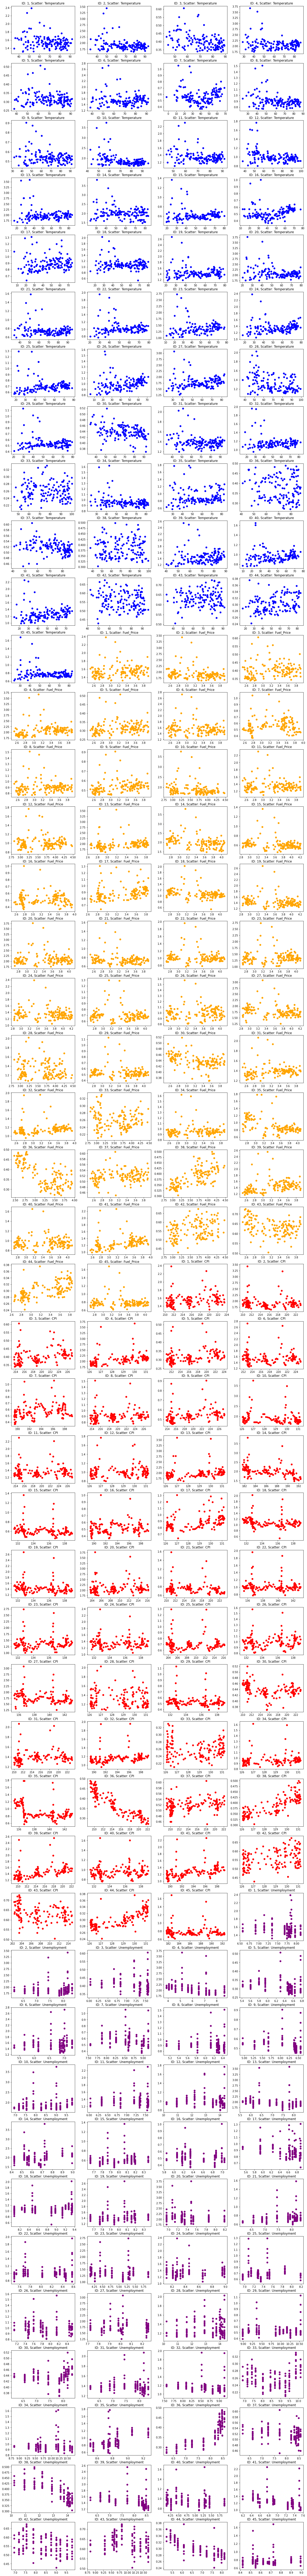

In [8]:
#Plotando Gráfico como Subplots - Definindo fig e axs
fig, axs = plt.subplots(45,4)
fig.set_figheight(180)
fig.set_figwidth(20)
index_s = 0
index_p = 0
index_c = 0
indicadores = ["Temperature","Fuel_Price","CPI","Unemployment"]
color = ["blue","orange","red","purple"]
for indicador in (indicadores):
    for loja in range(1,46):
        Dados = dft.loc[df["Store"]==loja,:]
        axs[index_p,index_s].scatter(Dados[indicador],Dados["Weekly_Sales"]/1000000, c=color[index_c]) # Weekly_Sales em Milhão
        axs[index_p,index_s].set_title(f"ID: {loja}, Scatter: {indicadores[index_c]}")
        if index_s == 3:
            index_s = 0
            index_p +=1
        else:
            index_s +=1
    index_c += 1
plt.show()

`DataFrame de Correlações`

Nesta seção será criado um DataFrame exclusivo para correlações das features com a target, a fim de distinguir atraves de grupos as relações que cada uma das features de cada loja têm com suas vendas semanais.
A fim de aprofundar 

In [9]:
#dft.Date = pd.to_datetime(dft.Date)
#dfo = dft.sort_values(by="Date")
#Definindo Indicadores - Para Realizar Corr
#indicadores = ["Temperature","Fuel_Price","CPI","Unemployment"]
#target = "Weekly_Sales"
#store = "Store"
#Criando DataFrame de Correlação das Features com Target
#Correlation = correlacao(dfo,indicadores, target, store)

#Checando DataFrame para Temperature
#Correlation.head(5)

,Temperature,Fuel_Price,CPI,Unemployment
1,-0.222701,0.124592,0.225408,-0.097955
2,-0.297673,-0.196375,-0.062431,0.066325
3,-0.377524,0.140886,0.317250,-0.230413
4,-0.225583,0.211549,0.351157,-0.337015
5,-0.175517,0.167352,0.308261,-0.207043


In [10]:
#for indicador in indicadores:
#    Correlation['Corr_' + indicador] = Correlation[indicador].apply(grupo)
#Correlation.head(5)

,Temperature,Fuel_Price,CPI,Unemployment,Corr_Temperature,Corr_Fuel_Price,Corr_CPI,Corr_Unemployment
1,-0.222701,0.124592,0.225408,-0.097955,0,0,0,0
2,-0.297673,-0.196375,-0.062431,0.066325,0,0,0,0
3,-0.377524,0.140886,0.317250,-0.230413,-1,0,1,0
4,-0.225583,0.211549,0.351157,-0.337015,0,0,1,-1
5,-0.175517,0.167352,0.308261,-0.207043,0,0,1,0


____

In [11]:
Date = lista_datas()
Date_ = []
index1 = [0,0,0,0]
index2 = []
index3 = []
for e in range(len(Date)-1):
    if Date[e][-1] == "0":
        index1.append(Date[e])
    elif Date[e][-1] == "1":
        index2.append(Date[e])
    else:
        index3.append(Date[e])
Date_.append(index1)
Date_.append(index2)
Date_.append(index3)
print(f"Data Inicial: {Date_[0][4]}, Data Limite 2010: {Date_[0][-1]}")
print(f"Data Inicial 2011: {Date_[1][0]} Data Limite 2011: {Date_[1][-1]}")
print(f"Data Inicial 2012: {Date_[2][0]} Data Limite 2011: {Date_[2][-1]}")

Data Inicial: 05-02-2010, Data Limite 2010: 31-12-2010
Data Inicial 2011: 07-01-2011 Data Limite 2011: 30-12-2011
Data Inicial 2012: 06-01-2012 Data Limite 2011: 19-10-2012


In [12]:
# criando dataframes para os anos separadamente

data_2010 = dft.loc[dft["Date"] <= '31/12/2010']
data_2011 = dft.loc[dft["Date"] > '31/12/2010']
data_2011 = data_2011.loc[data_2011['Date'] <= '31/12/2011']
data_2012 = dft.loc[dft["Date"] > '31/12/2011']



In [13]:
WS_2010 = []
Temp_2010 = []
Fuel_2010 = []
CPI_2010 = []
Unemp_2010 = []

WS_2012 = []
Temp_2012 = []
Fuel_2012 = []
CPI_2012 = []
Unemp_2012 = []
for e in range(0,180):
    WS_2010.append(0)
    Temp_2010.append(0)
    Fuel_2010.append(0)
    CPI_2010.append(0)
    Unemp_2010.append(0)
for e in data_2010["Weekly_Sales"]:
    WS_2010.append(e)
for e in data_2010["Temperature"]:
    Temp_2010.append(e)
for e in data_2010["Fuel_Price"]:
    Fuel_2010.append(e)
for e in data_2010["CPI"]:
    CPI_2010.append(e)
for e in data_2010["Unemployment"]:
    Unemp_2010.append(e)

    

for e in data_2012["Weekly_Sales"]:
    WS_2012.append(e)
for e in data_2012["Temperature"]:
    Temp_2012.append(e)
for e in data_2012["Fuel_Price"]:
    Fuel_2012.append(e)
for e in data_2012["CPI"]:
    CPI_2012.append(e)
for e in data_2012["Unemployment"]:
    Unemp_2012.append(e)
for e in range (0,405):
    WS_2012.append(0)
    Temp_2012.append(0)
    Fuel_2012.append(0)
    CPI_2012.append(0)
    Unemp_2012.append(0)
    

DataT = pd.DataFrame()
DataT["Store ID"] = data_2011["Store"]
DataT["WS 2010"] = WS_2010
DataT["WS 2011"] = data_2011["Weekly_Sales"]
DataT["WS 2012"] = WS_2012
DataT["Temp 2010"] = Temp_2010
DataT["Temp 2011"] = data_2011["Temperature"]
DataT["Temp 2012"] = Temp_2012
DataT["Fuel 2010"] = Fuel_2010
DataT["Fuel 2011"] = data_2011["Fuel_Price"]
DataT["Fuel 2012"] = Fuel_2012
DataT["CPI 2010"] = CPI_2010
DataT["CPI 2011"] = data_2011["CPI"]
DataT["CPI 2012"] = CPI_2012
DataT["Unemp 2010"] = Unemp_2010
DataT["Unemp 2011"] = data_2011["Unemployment"]
DataT["Unemp 2012"] = Unemp_2012


Lista_X = []
Lista_Y = []
Lista_Z = []
Lista_M = []
Lista_N = []
Lista_Index = DataT["WS 2010"].index
for e in Lista_Index:
    if DataT["WS 2010"][e] == 0:
        x = (DataT["WS 2011"][e] + DataT["WS 2012"][e])/2
        y = (DataT["Temp 2011"][e] + DataT["Temp 2012"][e])/2
        z = (DataT["Fuel 2011"][e] + DataT["Fuel 2012"][e])/2
        m = (DataT["CPI 2011"][e] + DataT["CPI 2012"][e])/2
        n = (DataT["Unemp 2011"][e] + DataT["Unemp 2012"][e])/2
    elif DataT["WS 2012"][e] == 0:
        x = (DataT["WS 2010"][e] + DataT["WS 2011"][e])/2
        y = (DataT["Temp 2010"][e] + DataT["Temp 2011"][e])/2
        z = (DataT["Fuel 2010"][e] + DataT["Fuel 2011"][e])/2
        m = (DataT["CPI 2010"][e] + DataT["CPI 2011"][e])/2
        n = (DataT["Unemp 2010"][e] + DataT["Unemp 2011"][e])/2
    else:
        x = (DataT["WS 2010"][e] + DataT["WS 2011"][e] + DataT["WS 2012"][e])/3
        y = (DataT["Temp 2010"][e] + DataT["Temp 2012"][e]) + DataT["Temp 2011"][e]/3
        z = (DataT["Fuel 2010"][e] + DataT["Fuel 2012"][e]) + DataT["Fuel 2011"][e]/3
        m = (DataT["CPI 2010"][e] + DataT["CPI 2012"][e]) + DataT["CPI 2011"][e]/3
        n = (DataT["Unemp 2010"][e] + DataT["Unemp 2012"][e]) + DataT["Unemp 2011"][e]/3
    Lista_X.append(x)
    Lista_Y.append(y)
    Lista_Z.append(z)
    Lista_M.append(m)
    Lista_N.append(n)
    
    
Average = pd.DataFrame()
Average["Store ID"] = data_2011["Store"]
Average["Avr WS"] = Lista_X
Average["Avr Temp"] = Lista_Y
Average["Avr Fuel"] = Lista_Z
Average["Avr CPI"] = Lista_M
Average["Avr Unemp"] = Lista_N
Average.head(5)

,Store ID,Avr WS,Avr Temp,Avr Fuel,Avr CPI,Avr Unemp
48,1,1497551.100,48.640,3.0665,215.559500,7.545
49,1,1425307.565,41.965,3.1220,215.674969,7.545
50,1,1360899.630,49.075,3.1420,215.906462,7.545
51,1,1318112.450,49.045,3.1500,216.137955,7.545
52,1,1621484.615,49.410,3.1745,216.369448,7.545


In [14]:
indicadores = ["Avr Temp","Avr Fuel", "Avr CPI", "Avr Unemp"]
target = "Avr WS"
store = "Store ID"
Average_Corr = correlacao(Average, indicadores, target, store)
Average_Corr

,Avr Temp,Avr Fuel,Avr CPI,Avr Unemp
1,-0.385470,-0.150815,0.253445,0.058035
2,0.312047,0.484127,-0.707416,0.346999
3,-0.483220,-0.067440,-0.991568,-0.966945
4,-0.536774,-0.585373,-0.630713,-0.605734
5,0.163041,0.418692,0.203006,0.193056
6,-0.708260,-0.064903,-0.171687,0.405203
7,0.357541,-0.163539,-0.938420,-0.008278
8,-0.055858,-0.046117,-0.842211,0.583632
9,-0.170990,0.313271,0.020394,0.021282
10,-0.562863,-0.571562,0.185462,-0.729254


#### Agrupando as correlações por grupo

In [15]:
for indicador in indicadores:
    Average_Corr['Corr_' + indicador] = Average_Corr[indicador].apply(grupo)
Average_Corr.head(5)

,Avr Temp,Avr Fuel,Avr CPI,Avr Unemp,Corr_Avr Temp,Corr_Avr Fuel,Corr_Avr CPI,Corr_Avr Unemp
1,-0.385470,-0.150815,0.253445,0.058035,-1,0,0,0
2,0.312047,0.484127,-0.707416,0.346999,1,1,-1,1
3,-0.483220,-0.067440,-0.991568,-0.966945,-1,0,-1,-1
4,-0.536774,-0.585373,-0.630713,-0.605734,-1,-1,-1,-1
5,0.163041,0.418692,0.203006,0.193056,0,1,0,0


### Preparando a base de dados para os modelos de regressão

#### A base de dados

In [16]:
Average

,Store ID,Avr WS,Avr Temp,Avr Fuel,Avr CPI,Avr Unemp
48,1,1497551.100,48.640,3.0665,215.559500,7.5450
49,1,1425307.565,41.965,3.1220,215.674969,7.5450
50,1,1360899.630,49.075,3.1420,215.906462,7.5450
51,1,1318112.450,49.045,3.1500,216.137955,7.5450
52,1,1621484.615,49.410,3.1745,216.369448,7.5450
...,...,...,...,...,...,...
6387,45,877472.355,45.560,3.2490,185.585025,8.6235
6388,45,979759.825,38.555,3.2620,185.603211,8.6235
6389,45,1101094.265,35.220,3.2765,185.657833,8.6235
6390,45,1602410.010,36.430,3.2650,185.737283,8.6235


In [17]:
X = Average[['Avr Temp', 'Avr Fuel', 'Avr CPI', 'Avr Unemp']]
Y = Average['Avr WS']

#### Separando o conjunto de dados, base de teste e base de treinamento
##### Será usado em todos os modelos de regressão

In [18]:
X = Average[['Avr Temp', 'Avr Fuel', 'Avr CPI', 'Avr Unemp']]
Y = Average['Avr WS']

# vetores que receberam as informações separadas por lojas
Xi = []
Yi = []
# percorrendo loja a loja, temos:
# vamos utilizar a base de teste com um size de 18%
for loja in range(1,46):
    dff = Average.loc[Average['Store ID'] == loja, :]
    x = dff[['Avr Temp','Avr Fuel','Avr CPI','Avr Unemp']]
    y = dff['Avr WS']
    X_train,X_test,y_train,y_test=train_test_split(x,y, random_state=42,test_size=0.18)
    Xi.append([X_train,X_test])
    Yi.append([y_train,y_test])

### Primeiro Modelo: Regressão Linear

In [19]:
#==== Banco de Variaveis e Resultados ====
#Tipos de Score
maior_score_test = 0
melhor_id_loja   = 0
pior_score_test  = 1 # pq esse é maior dado, dai sera menor que todos os dados analizamos
pior_id_loja     = 0
lojas_alpha_maior_90 = []
#Informações Unitarias (Cada Store ID)
Coef_Reg = []
Mean_Squared = []
R_Squared = []
#Predição
Y_Prediction = []
Y_Train = []


for loja in range(0,45): 
    #==== Criando Variaveis e Objetos ====
    regr = linear_model.LinearRegression()
    
    #=== Treinamento do Modelo ====
    # Treinamento Modelo - Usando X_Train e Y_Train
    regr.fit(Xi[loja][0], Yi[loja][0])
    # Predição de Y - Usando X_Test
    sales_y_pred = regr.predict(Xi[loja][1])
    Y_Prediction.append(sales_y_pred)

    #Create linear regression object
    score_train = regr.score(Xi[loja][0], Yi[loja][0])
    score_test = regr.score(Xi[loja][1], Yi[loja][1])
    
    #==== Coletando Informações Sobre Modelo ====
    #Coletando diferentes tipos de Score:
    if score_test > maior_score_test:
        maior_score_test = score_test
        melhor_id_loja = loja + 1 #Adição é realizada por materia de Index e Apresentação
    if score_test < pior_score_test:
        pior_score_test = score_test
        pior_id_loja = loja + 1 #Adição é realizada por materia de Index e Apresentação
    if score_test >= 0.9:
        lojas_alpha_maior_90.append(loja+1)
    #Coeficiente de regressão
    const = [regr.intercept_]
    const.extend(regr.coef_) #.extend = Extender lista para adicionar const ao inicio
    Coef_Reg.append(const)
    
    #Média Quadratica
    m = mean_squared_error(Yi[loja][1], sales_y_pred)
    Mean_Squared.append(m)
    #R Quadrado
    r = r2_score(Yi[loja][1], sales_y_pred)
    R_Squared.append(r)
    
    
print(f'A loja com o maior score de test foi {melhor_id_loja}, cujo score foi de {maior_score_test}')
print(f'A loja com o pior score de test foi {pior_id_loja}, cujo score foi de {pior_score_test}')
print(f'As lojas cujo score foi maior ou igual a 90% foram: {lojas_alpha_maior_90}')

A loja com o maior score de test foi 3, cujo score foi de 0.9928805898614836
A loja com o pior score de test foi 29, cujo score foi de -0.8385025740321459
As lojas cujo score foi maior ou igual a 90% foram: [3, 28, 30, 36, 37, 38, 42]


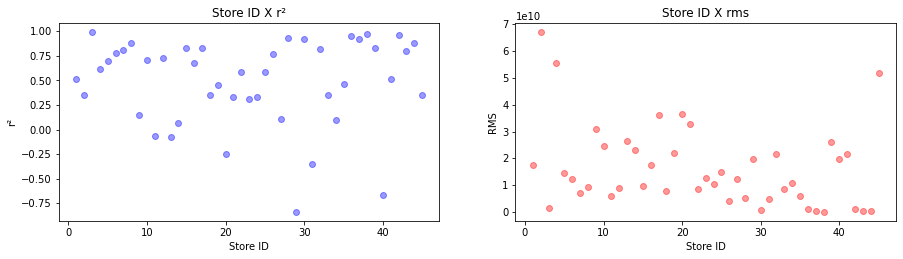

In [20]:
st = np.arange(1,46,1)
plt.figure(figsize=(15,8))

plt.subplot(221)
plt.scatter(st, R_Squared,c='blue', alpha=0.4)
plt.title('Store ID X r²')
plt.xlabel('Store ID')
plt.ylabel('r²')

plt.subplot(222)
plt.scatter(st, Mean_Squared,c='red', alpha=0.4)
plt.title('Store ID X rms')
plt.xlabel('Store ID')
plt.ylabel('RMS')
plt.show()

### Conclusão sobre o modelo 1: Regressão Linear

<li> Temos uma alta variabilidade dos scores do modelo, sendo que uns são negativos. A biblioteca resalta essa possibilidade, ocorre quando o modelo é muito ruim para essa regressão.
<li> De acordo com o gráfico do ID da loja em função do erro médio quadratico (rms), percebe-se que temos uma alta variabilidade de erros, distoam do ideam, 0, sendo assim um modelo inadequado para a grande maioria das lojas.

### Segundo Modelo: Regressor Tree 

<Br> A base de dados já está separada em treinamento e teste, basta acessar os vetores Xi e Yi
<Br> Sendo Xi[loja][0] o x de treinamento para uma dada loja
<Br> Sendo Xi[loja][1] o x de teste para uma dada loja
<Br> Sendo Yi[loja][0] o y de treinamento para uma dada loja
<Br> Sendo Yi[loja][1] o y de teste para uma dada loja
<Br>
<Br> Onde loja é o ID loja - 1, deste modo, variando de 0 a 44.

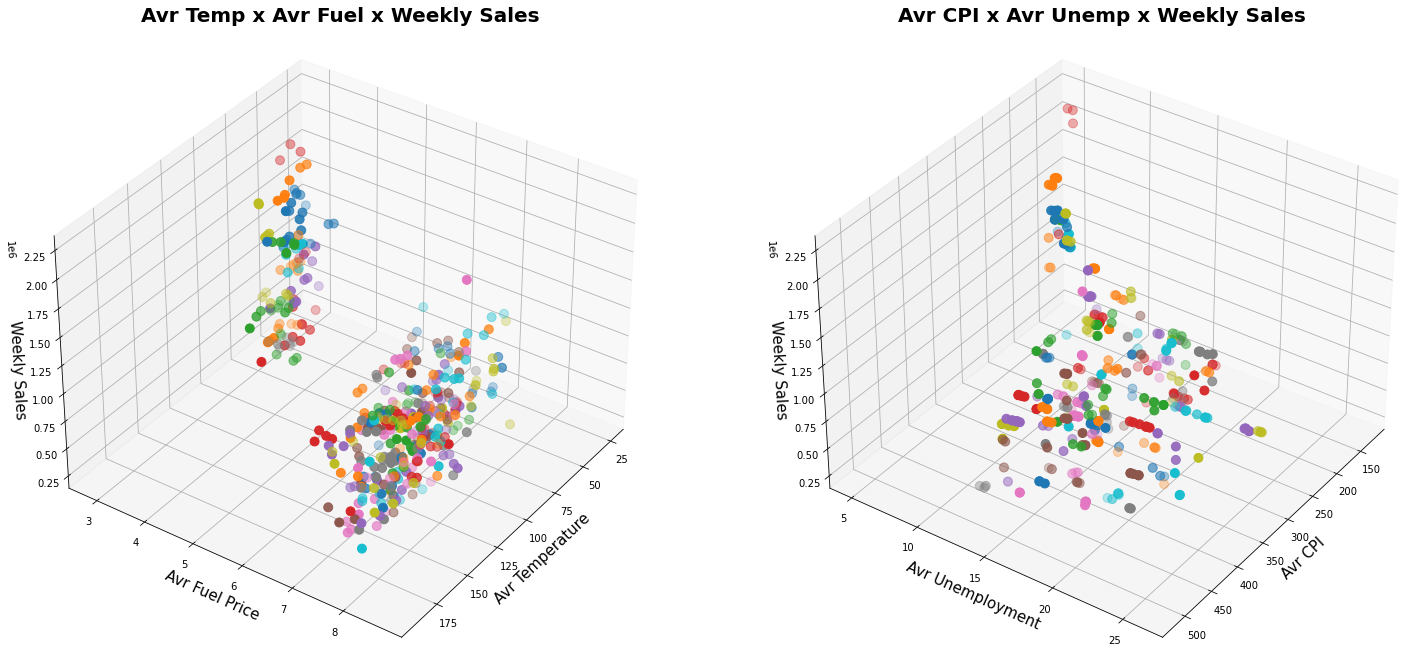

In [41]:
#==== Banco de Variaveis e Resultados ====
#Informações unitarias (Cada Store ID)
Coef_Reg2 = []
Mean_Squared2 = []
R_Squared2 = []
#Predição
Y_Prediction2 = []
fig = plt.figure(figsize=(25,16))
ax = fig.add_subplot(121,projection="3d")
ax2 = fig.add_subplot(122,projection="3d")
ax.set_xlabel("Avr Temperature", fontsize=15)
ax.set_ylabel("Avr Fuel Price", fontsize=15)
ax.set_zlabel("Weekly Sales",fontsize=15)
ax.view_init(35,35)
ax.set_title("Avr Temp x Avr Fuel x Weekly Sales",fontsize=20, fontweight=750)
ax2.set_xlabel("Avr CPI",fontsize=15)
ax2.set_ylabel("Avr Unemployment",fontsize=15)
ax2.set_zlabel("Weekly Sales",fontsize=15)
ax2.view_init(35,35)
ax2.set_title("Avr CPI x Avr Unemp x Weekly Sales",fontsize=20, fontweight=750)

for loja in range(0,45):
    #==== Criando Variaveis e Objetos ====
    # Regrassão 2 - TreeRegressor
    regr_1 = DecisionTreeRegressor(max_depth=2)
    regr_1.fit(Xi[loja][0], Yi[loja][0]) #Dados de Treinamento
    # Previsão
    sales_y_pred2 = regr_1.predict(Xi[loja][1])
    Y_Prediction2.append(sales_y_pred2)
    
    #Coeficiente de regressão
    const2 = [regr.intercept_]
    const2.extend(regr.coef_)
    Coef_Reg2.append(const)
    
    #Média Quadratica
    m2 = mean_squared_error(Yi[loja][1], sales_y_pred2)
    Mean_Squared2.append(m2)
    #R Quadrado
    r2 = r2_score(Yi[loja][1], sales_y_pred2)
    R_Squared2.append(r2)
    
    #Plot Gráfico 3D - Avr's Temp, Fuel, CPI, Unemp x Weekly_Sales
    ax.scatter3D(Xi[loja][1]["Avr Temp"],Xi[loja][1]["Avr Fuel"],sales_y_pred2,s=80) 
    ax2.scatter3D(Xi[loja][1]["Avr CPI"],Xi[loja][1]["Avr Unemp"],sales_y_pred2,s=80)  
plt.show()

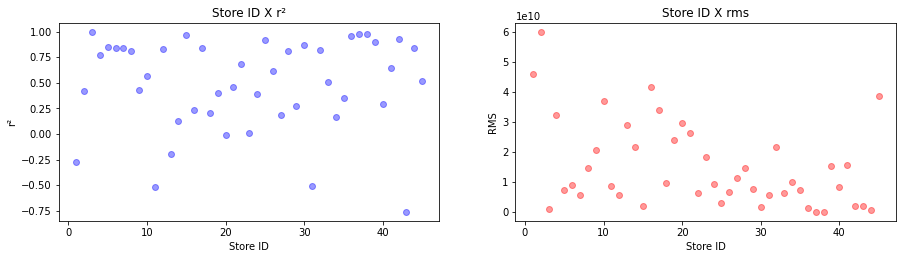

In [42]:
plt.figure(figsize=(15,8))

plt.subplot(221)
plt.scatter(st, R_Squared2,c='blue', alpha=0.4)
plt.title('Store ID X r²')
plt.xlabel('Store ID')
plt.ylabel('r²')

plt.subplot(222)
plt.scatter(st, Mean_Squared2,c='red', alpha=0.4)
plt.title('Store ID X rms')
plt.xlabel('Store ID')
plt.ylabel('RMS')
plt.show()

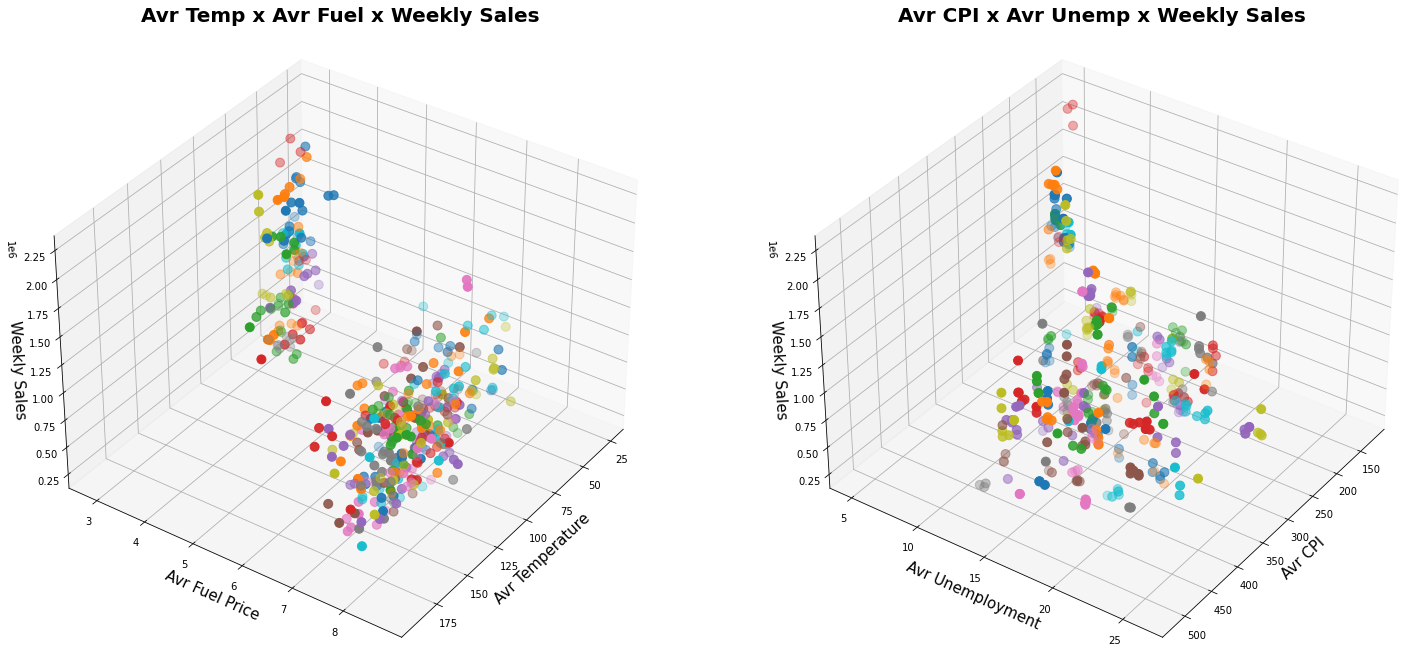

In [43]:
#==== Banco de Variaveis e Resultados ====
#Informações unitarias (Cada Store ID)
Coef_Reg3 = []
Mean_Squared3 = []
R_Squared3 = []
#Predição
Y_Prediction3 = []
fig = plt.figure(figsize=(25,16))
ax3 = fig.add_subplot(121,projection="3d")
ax4 = fig.add_subplot(122,projection="3d")
ax3.set_xlabel("Avr Temperature", fontsize=15)
ax3.set_ylabel("Avr Fuel Price", fontsize=15)
ax3.set_zlabel("Weekly Sales",fontsize=15)
ax3.view_init(35,35)
ax3.set_title("Avr Temp x Avr Fuel x Weekly Sales",fontsize=20, fontweight=750)
ax4.set_xlabel("Avr CPI",fontsize=15)
ax4.set_ylabel("Avr Unemployment",fontsize=15)
ax4.set_zlabel("Weekly Sales",fontsize=15)
ax4.view_init(35,35)
ax4.set_title("Avr CPI x Avr Unemp x Weekly Sales",fontsize=20, fontweight=750)

for loja in range(0,45):
    #==== Criando Variaveis e Objetos ====
    # Regrassão 2 - TreeRegressor
    regr_2 = DecisionTreeRegressor(random_state=0)
    regr_2.fit(Xi[loja][0], Yi[loja][0]) #Dados de Treinamento
    # Previsão
    sales_y_pred3 = regr_2.predict(Xi[loja][1])
    Y_Prediction3.append(sales_y_pred3)
    
    #Coeficiente de regressão
    const3 = [regr.intercept_]
    const3.extend(regr.coef_)
    Coef_Reg3.append(const)
    
    #Média Quadratica
    m3 = mean_squared_error(Yi[loja][1], sales_y_pred3)
    Mean_Squared3.append(m3)
    #R Quadrado
    r3 = r2_score(Yi[loja][1], sales_y_pred3)
    R_Squared3.append(r3)
    
    
    ax3.scatter3D(Xi[loja][1]["Avr Temp"],Xi[loja][1]["Avr Fuel"],sales_y_pred3,s=80) 
    ax4.scatter3D(Xi[loja][1]["Avr CPI"],Xi[loja][1]["Avr Unemp"],sales_y_pred3,s=80)  
plt.show()

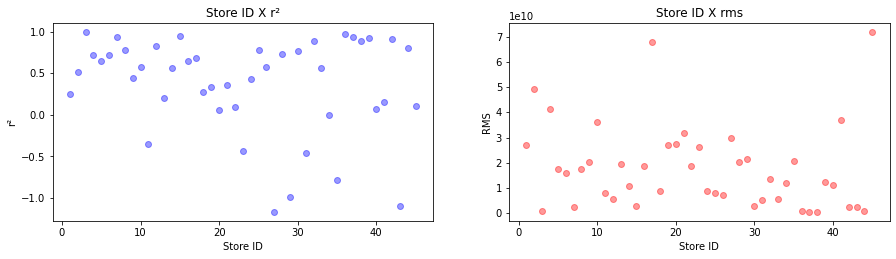

In [44]:
plt.figure(figsize=(15,8))

plt.subplot(221)
plt.scatter(st, R_Squared3,c='blue', alpha=0.4)
plt.title('Store ID X r²')
plt.xlabel('Store ID')
plt.ylabel('r²')

plt.subplot(222)
plt.scatter(st, Mean_Squared3,c='red', alpha=0.4)
plt.title('Store ID X rms')
plt.xlabel('Store ID')
plt.ylabel('RMS')
plt.show()

#### Referências 

<Br> https://scikit-learn.org/stable/modules/linear_model.html
<Br> https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
<Br> https://medium.com/pursuitnotes/decision-tree-regression-in-6-steps-with-python-1a1c5aa2ee16
<Br> https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
<Br> https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015/
<Br> https://scikit-learn.org/stable/modules/tree.html
<Br> https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py